# Tarea 1 - Redes: Medidor ancho de banda UDP
---
### *Pablo Skewes*

## Realización del experimento

In [1]:
from pathlib import Path
from tqdm import tqdm
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from medidor_bw_udp import compute_bandwidth
import jsockets

In [2]:
# FILEPATH = Path('/etc/services').resolve()
FILEPATH = Path('Tarea1_Redes.pdf').resolve()
SERVER_URL = 'anakena.dcc.uchile.cl'
SERVER_PORT = '1818'

In [9]:
results = []
packet_size = ['0001'] + [f'{x:04d}' for x in range(200, 10_000, 100)] + ['9999']

for size in tqdm(packet_size, desc="Computando BW para distintos tamaños de paquetes"):
    try:
        socket = jsockets.socket_udp_connect(SERVER_URL, SERVER_PORT)
        if socket is None:
            print("No se pudo abrir el socket")
            sys.exit(1)
        
        result = compute_bandwidth(
            socket=socket,
            packet_size=size,
            filepath=str(FILEPATH),
            verbose=False,
        )
    except:
        result = {
            
        }
    results.append(result)
    time.sleep(0.3)

Computando BW para distintos tamaños de paquetes:   0%|          | 0/100 [00:00<?, ?it/s]

Timeout, reenviando mensaje (1/5)
Timeout, reenviando mensaje (2/5)
Timeout, reenviando mensaje (3/5)
Timeout, reenviando mensaje (4/5)
Timeout, reenviando mensaje (5/5)
Se alcanzó el número máximo de reintentos


Computando BW para distintos tamaños de paquetes:   3%|▎         | 3/100 [00:53<19:40, 12.17s/it]  

Timeout, reenviando mensaje (1/5)


Computando BW para distintos tamaños de paquetes:   4%|▍         | 4/100 [01:04<18:20, 11.46s/it]

Timeout, reenviando mensaje (1/5)


Computando BW para distintos tamaños de paquetes:   5%|▌         | 5/100 [01:14<17:30, 11.06s/it]

Timeout, reenviando mensaje (1/5)


Computando BW para distintos tamaños de paquetes:  81%|████████  | 81/100 [01:52<00:06,  2.81it/s]

Timeout, reenviando mensaje (1/5)


Computando BW para distintos tamaños de paquetes:  83%|████████▎ | 83/100 [02:02<00:41,  2.45s/it]

Timeout, reenviando mensaje (1/5)


Computando BW para distintos tamaños de paquetes: 100%|██████████| 100/100 [02:18<00:00,  1.39s/it]


In [10]:
df = pd.DataFrame.from_records(results)
df['packet_size'] = packet_size
df['packet_size'] = df['packet_size'].astype(int)

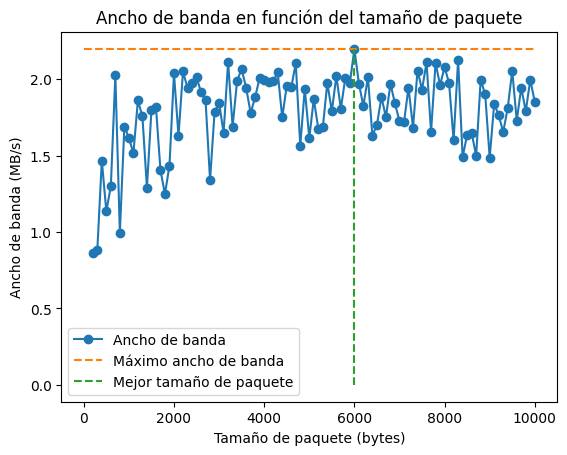

In [18]:
x = df['packet_size']
y = df['bandwidth']

max_value = y.max()
best_packet_size = x[y.idxmax()]

plt.plot(x, y, 'o-', label='Ancho de banda')
plt.plot(x, [max_value] * len(x), '--', label='Máximo ancho de banda')
plt.plot([best_packet_size] * 2, [0, max_value], '--', label='Mejor tamaño de paquete')
plt.xlabel('Tamaño de paquete (bytes)')
plt.ylabel('Ancho de banda (MB/s)')
plt.title('Ancho de banda en función del tamaño de paquete')
plt.legend();

## Pregunta 1

*Genere algunos experimentos con diversos tamanos de paquete y haga una recomendacion de tamaño de paquete a utilizar en base a sus resultados (entregar los experimentos realizados y
sus resultados junto con las conclusiones). Incluya los valores 1 y 9999 en sus pruebas. Grafique sus resultados.*

Del gráfico se puede ver que el tamaño de paquete recomendable para este experimento es 6000 bytes, que obtiene un ancho de banda de aproximadamente 2.3 Mbps. Sin embargo es importante mencionar que estos fueron los resultados específicos para este experimento, y que pueden variar para distintas iteraciones. Tras algunas iteraciones e intentos a manos parece ser que un tamaño mayor a 5000 puede funcionar bien.

## Pregunta 2

**La medición de ancho de banda obtenida es ”válida”:  al haber perdidas, ¿estamos midiendo mal? Los resultados obtenidos: ¿son coherentes? ¿se parecen a la realidad? Argumente con sus propias mediciones realizadas en el punto anterior. En particular, mire el caso de retransmision de ’C’ o ’E’: ¿afecta la medicion?**

Considero que la medición de banda ancha realizada es aproximativa pero no realmente "válida". 
Esto ya que al haber pérdidas, se pierde información que es necesaria para realizar la medición. Por ejemplo, si para un experimento se llega a perder la mitad de los paquetes, entonces estaríamos midiendo la velocidad con la que se envío "todo" el archivo cuando en realidad se logró envío la mitad.

Considero que a pesar de esto los resultados obtenidos son coherentes de alguna forma, ya que se puede ver que a medida que aumenta el tamaño de paquete, el ancho de banda también aumenta (hasta cierto punto). Lo cual tiene sentido ya que a mayor tamaño de paquete, se envían menos paquetes por segundo, por lo que se pierde menos tiempo en el envio de la información extra necesaria para indicar dónde enviar el paquete (overhead).


En cuanto a la retransmición de paquetes, considero que retransmitir el primer paquete (que comienza con ’C’) no afecta la medición, ya que se comienza a medir el tiempo desde que se envía el primer paquete (es decir el primer mensaje que comienza con "D"), por lo que si el primer paquete se tiene que reenviar porque se perdió, esto no afectaría la medición. Sin embargo, si se retransmite el paquete que comienza con ’E’, esto sí afectaría la medición, ya que el tiempo se empieza a contar desde justo antes de enviar el primer paquete con 'D' hasta justo después de recibir el último paquete con 'E' por parte del servidor. Por lo que si se retransmite el paquete con 'E', se estaría contando un tiempo mayor al real. Esto se podría formular aproximadamente como:

$$  T_{envío} = \sum_{d \in \text{paquetes}} (T_{d}) +  N_{\text{intentos de envío de E}} * (T_{timeout} + T_{\text{envío "real" de E}}) $$

(Aclaración: el segundo valor de la suma está fuera de la sumatoria)

Aunque, dado que el código del cliente uno puede contar cuántas veces se hace el retry y uno cononce el tiempo de timeout, se podría restar el tiempo de retransmisión de E al tiempo total de envío, por lo que se podría obtener una medición más precisa. Sin embargo esto seguiría sin solucionar el problema de la pérdida de información que mencioné anteriormente.

Punto a parte, además de la pérdida de paquetes, otra imperfección que podría ocurrir es, qué pasa si el último paquete que envía el cliente (el paquete que contiene solo una "E") llega antes que algún paquete que contiene el archivo? En este caso también habría perdida de información.

## Pregunta 3

**Si el tamaño del archivo de entrada es exactamente igual a los bytes reportados por el servidor ¿podemos ahí estar seguros que la medicion es válida?**

Como mencioné anteriormente, la pérdida de paquetes sí es un problema que afecta en la medición, por lo que si el tamaño del archivo de entrada es exactamente igual a los bytes reportados por el servidor, entonces en teoría significa que todos los paquetes llegaron correctamente al servidor, por lo que la medición sería "válida". Ahora, eso no soluciona el problema del retry del envió de "E" por parte del cliente, por lo que también ayudaría la solución que mencioné anteriormente. 

A pesar de esto, la verdad es dificil decir qué se considera como "válido" ya que en la red siempre van a haber imperfecciones que afecten la medición, por lo que no se puede obtener una medición 100% precisa, pero considero que se puede decir con seguridad que en este caso la medición es mejor que en el caso anterior.

## Pregunta 4

**¿El servidor no debería hacer lo mismo y repetir el ’E’ hasta que
el cliente lo reciba? ¿O esto generaría posibilidades de error?
¿podría afectar la medicion?**

Si el servidor hiciera esto, también afectaría la medición de la misma forma que expliqué para el caso en el que el cliente debe reenviar el paquete con la E. Esto ya que el servidor también estaría reenviando un paquete, por lo que se estaría contando un tiempo mayor al real.

Quizá esto también podría corregirse un poco si, en el código del servidor, se contara cuántas veces se reenvía el paquete con la E, y que esta información se codificara también en el paquete a enviar al cliente. De esta forma, el cliente podría restar el tiempo de reenvío de E al tiempo total de envío, por lo que se podría obtener una medición más precisa.

## Pregunta 5

**Uno podría no esperar el reporte del servidor y simplemente enviar el archivo y medir cuanto demora en escribirse en el socket y usar ese tiempo para el cálculo del ancho de banda. Explique por que eso está mal medido (les prometo que está mal medido).**

Si no considero la respuesta del servidor en el tiempo del cálculo, no tengo ninguna garantía de que los paquetes llegaron correctamente al servidor. Por poner un caso imaginemos que se pierde la mitad de los paquetes, entonces el cliente mediría el tiempo que le tomó "enviar" todos los paquetes, sin embargo la respuesta del servidor sería de que llegaron la mitad de los paquetes solamente, por lo que el cliente estaría midiendo un tiempo mayor al real ya que para el cálculo se usa la cantidad de bytes que indica el servidor. (Lo que daría un ancho de banda menor al real.)

## Pregunta 6

**Es una complicacion agregarle una ’D’ a cada paquete de datos enviado al servidor. ¿Por que no enviamos todo el archivo no mas, y luego un paquete ’E’ solo? Así, sería mas fácil y el servidor detecta el fin de la transmision cuando llega un paquete con una ’E’. ¿Funcionaría?**

Por un lado, si el archivo es muy grande, simplemente no puedo mandarlo en un sólo paquete ya que físicamente no se puede, hay un límite de tamaño que se puede enviar por la red.

Luego, si por ejemplo quisiéramos mandar el archivo particionado pero sin la "D" esto podría facilitar la aparición de bugs. Sin un protocolo no podemos estar seguros de que lo enviado corresponde a una parte del archivo. Incluso, el paquete final con la "E" podría confundirse con una parte del archivo. De hecho esto ocurría para todos los archivos de tamaño $n$ donde $n \equiv_{\text{packet size}} 1$. Por ejemplo: archivo = AABBE, packet_size=2, entonces el servidor recibiría: [AA, BB, E]. En este caso el servidor interpretaría que la última "E" corresponde al final del archivo, pero en realidad es parte del archivo. 

Por lo tanto no sería buena idea mandar los paquetes sin la "D".